In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

[*********************100%***********************]  1 of 1 completed


Optimization terminated successfully.
         Current function value: 0.689860
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 8168
Model:                          Logit   Df Residuals:                     8162
Method:                           MLE   Df Model:                            5
Date:                Sun, 13 Jul 2025   Pseudo R-squ.:                0.001004
Time:                        08:44:18   Log-Likelihood:                -5634.8
converged:                       True   LL-Null:                       -5640.4
Covariance Type:            nonrobust   LLR p-value:                   0.04521
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0784      0.043      1.810      0.070      -0.006       0.163
Volume      3.092e-10   2.61e

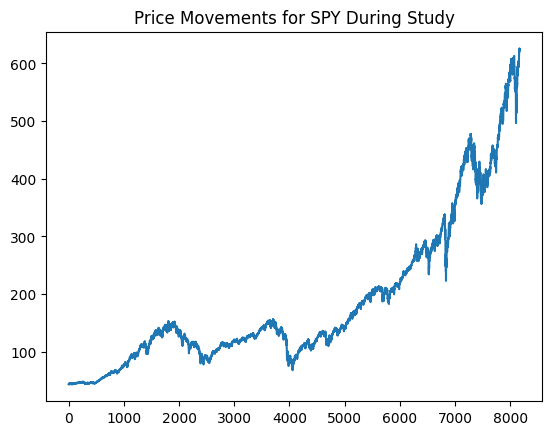

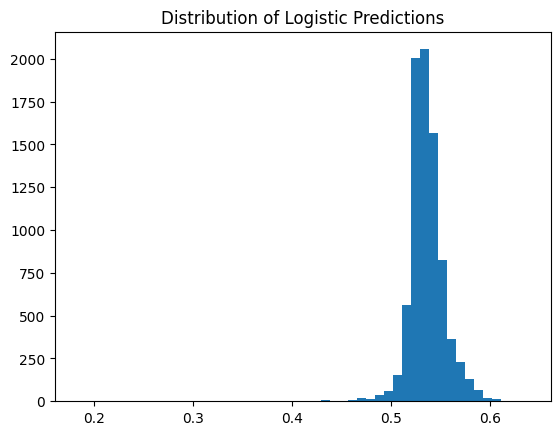

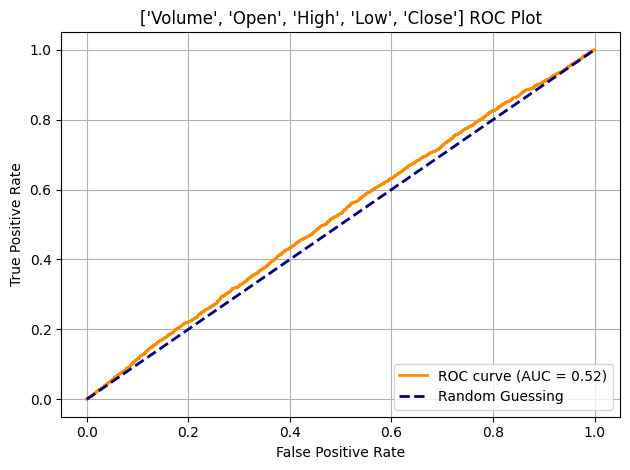

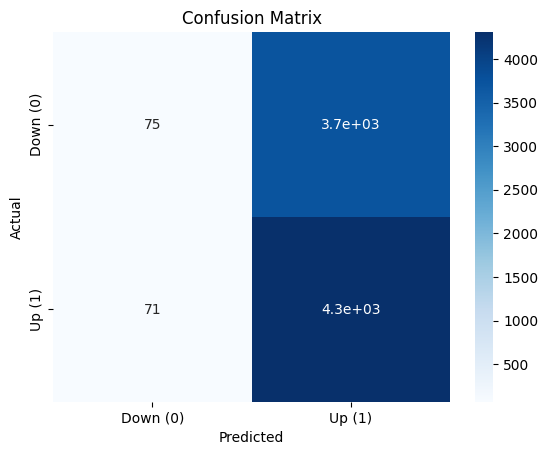

In [2]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

STRATEGY = ['Volume', 'Open', 'High', 'Low', 'Close', 'MACD_hist']

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    subset = df.iloc[-lookback:, :]
    plt.figure()
    plt.plot(subset['Close'])
    plt.title(f'Price Movements for {ticker} During Study')
    
    return subset

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    return df

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df['Target'] = (df[f'Close + {shift}'] >  df['Close']) * 1

    return df

def generate_regression_output(df, features=STRATEGY, target='Target'):
    subset = df[features + [target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.Logit(y, X_with_const).fit()

    y_pred_prob = model.predict(X_with_const)
    
    plt.figure()
    plt.hist(y_pred_prob, bins=50)
    plt.title('Distribution of Logistic Predictions')

    y_pred = (y_pred_prob > .5).astype(int)

    # Console summary
    print(model.summary())

    df['Prediction'] = y_pred

    return df, y, y_pred_prob

def add_confusion_matrix(df):

    cm = confusion_matrix(df['Target'], df['Prediction'])
    labels = ['Down (0)', 'Up (1)']

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()

    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='.0f')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    return df

def add_roc_plot(df, y_true, y_scores, title=f'{STRATEGY} ROC Plot'):

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_target(df)
    df, y, y_pred_prob = generate_regression_output(df)
    df = add_roc_plot(df, y_true=y, y_scores=y_pred_prob)
    df = add_confusion_matrix(df)

    return df

df = main()